# [Sec1] learning TF_Slim
Let's handle with mnist data with naive approach
- logist regression
- VGG 16
with the support of TF_Slim

In [1]:
# prepare the data first
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

#for _ in range(1000):
#    batch_xs, batch_ys = mnist.train.next_batch(100)
batch_xs, batch_ys = mnist.train.next_batch(100)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
print batch_xs.shape
print batch_ys.shape

(100, 784)
(100, 10)


In [3]:
import tensorflow.contrib.slim as slim
import tensorflow as tf

In [4]:
def LRmodel(images):
    with slim.arg_scope([slim.fully_connected],weights_regularizer=slim.l2_regularizer(0.01)):
        net = slim.fully_connected(images, 70, scope='fc1')
        net = slim.fully_connected(net, 10, scope='fc2')
    return net

## As you can see we easily create a model with imput and adding fc.
## now need to create a tensor for puting images and labels
### for the tensorflow like training rule , we need to add placeholder ,and with for loop to loop data

In [5]:
tf.reset_default_graph()

In [6]:
images = tf.placeholder(tf.float32, shape=(None, 784))
labels = tf.placeholder(tf.float32, shape=(None, 10))
# connecting to network
net = LRmodel(images)
#calculate loss 
classification_loss = tf.losses.softmax_cross_entropy(onehot_labels=labels, logits=net)
# adding  optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.01).minimize(classification_loss)

# operator for accuracy
predictions = tf.argmax(net, 1)
ground_truth = tf.argmax(labels, 1)
acc = tf.reduce_mean(tf.cast(tf.equal(predictions, ground_truth), tf.float32))

In [7]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(1000):
        batch_xs, batch_ys = mnist.train.next_batch(5000)
        if i %100==0:
            print("the {}-th acc".format(str(i)), sess.run(acc,feed_dict={images:batch_xs,labels:batch_ys}))
        sess.run(optimizer,feed_dict={images:batch_xs,labels:batch_ys})
    print( "the overall testing acc is ",acc.eval(feed_dict={images: mnist.test.images, labels: mnist.test.labels}))

('the 0-th acc', 0.099799998)
('the 100-th acc', 0.77119982)
('the 200-th acc', 0.78499985)
('the 300-th acc', 0.79579979)
('the 400-th acc', 0.78839976)
('the 500-th acc', 0.79919976)
('the 600-th acc', 0.7907998)
('the 700-th acc', 0.78999984)
('the 800-th acc', 0.78639978)
('the 900-th acc', 0.80239975)
('the overall testing acc is ', 0.77470005)


# Learn Threading Queue

In [8]:
import threading

In [9]:
def MyLoop(coord):
    print 'helloworld'
    coord.request_stop()

# Main thread: create a coordinator.
coord = tf.train.Coordinator()

# Create 10 threads that run 'MyLoop()'
threads = [threading.Thread(target=MyLoop, args=(coord,)) for i in xrange(10)]

# Start the threads and wait for all of them to stop.
for t in threads:
    t.start()
print 'QQQQQQQQQQQ'
coord.join(threads)
print 'kerker will always the last one'

 helloworldhelloworld

helloworld
helloworldhelloworld
 
helloworldhelloworld

helloworld
helloworld
helloworldQQQQQQQQQQQ

kerker will always the last one


## Currently we didn't follow the slim provided rules
## slim provide serveral data access way , let's take a look how magic it is

Before training , let's learn tfrecord, I have many time!!

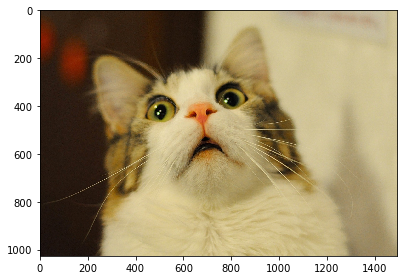

In [10]:
%matplotlib inline

import numpy as np
import skimage.io as io

cat_img = io.imread('cat.jpg')
io.imshow(cat_img)

### Let's convert the picture into string representation

True


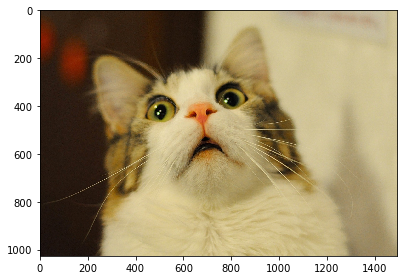

In [11]:
# using the ndarray.tostring() function 
cat_string = cat_img.tostring()

# Now let's convert the string back to the image
# Important: the dtype should be specified
# otherwise the reconstruction will be errorness
# Reconstruction is 1d, so we need sizes of image
# to fully reconstruct it.
reconstructed_cat_1d = np.fromstring(cat_string, dtype=np.uint8)

# Here we reshape the 1d representation
# This is the why we need to store the sizes of image
# along with its serialized representation.
reconstructed_cat_img = reconstructed_cat_1d.reshape(cat_img.shape)

# Let's check if we got everything right and compare
# reconstructed array to the original one.
print np.allclose(cat_img, reconstructed_cat_img)
io.imshow(reconstructed_cat_img)

### Ok, now we have some approach to convert np array to string
### Let's go on write to tfrecord

In [15]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)
batch_xs, batch_ys = mnist.train.next_batch(100)
batch_ys[:5]

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


array([2, 9, 6, 3, 6], dtype=uint8)

In [18]:
batch_xs.shape

(100, 784)

In [25]:
import os
def _int64_feature(value):
      return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
      return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
    
def convert_to(images, labels,name):
    """Converts a dataset to tfrecords."""
    if images.shape[0] != labels.shape[0]:
        raise ValueError('Images size %d does not match label size %d.' %(images.shape[0], num_examples))
    num_examples = images.shape[0]
    filename = os.path.join(name + '.tfrecords')
    print('Writing', filename)
    writer = tf.python_io.TFRecordWriter(filename)
    for index in range(num_examples):
        image_raw = images[index].tostring()
        example = tf.train.Example(features=tf.train.Features(feature={
            'label': _int64_feature(int(labels[index])),
            'image_raw': _bytes_feature(image_raw)}))
        writer.write(example.SerializeToString())
    writer.close()
    print('Done')

In [26]:
convert_to(batch_xs,batch_ys,'trial')

('Writing', 'trial.tfrecords')
Done


### let's read it back and compare to original image

In [54]:
import tensorflow as tf

filename = "trial.tfrecords"
for serialized_example in tf.python_io.tf_record_iterator(filename):
    example = tf.train.Example()
    example.ParseFromString(serialized_example)

    # traverse the Example format to get data
    image = example.features.feature['image_raw'].bytes_list .value
    label = example.features.feature['label'].int64_list.value[0]


In [55]:
# you need to check how the original dtype is
reconstructed_image = np.fromstring(image[:][0], dtype=np.float32)
print np.allclose(batch_xs[99],reconstructed_image)

True


### now we has checked that we can restore images from tfrecords.
### And we have some intuition that how tfrecords works. Let's make hole mnist as tfrecords.

In [59]:
print mnist.train.images.shape
print mnist.train.labels.shape
print mnist.test.images.shape
print mnist.test.labels.shape

(55000, 784)
(55000,)
(10000, 784)
(10000,)


In [60]:
print 'now handling training set'
convert_to(mnist.train.images,mnist.train.labels,'training_set')
print 'now handling testing set'
convert_to(mnist.test.images,mnist.test.labels,'testing_set')

now handling training set
('Writing', 'training_set.tfrecords')
Done
now handling testing set
('Writing', 'testing_set.tfrecords')
Done


In [64]:
print "======= current tf list ======="
! ls | grep tfrecords

======= current tf list =======
testing_set.tfrecords
training_set.tfrecords
trial.tfrecords


### Tfrecord  \
- reader: TFRecordReader
- file_queue
- parse_single_example

這個地方蠻複雜的覽的打英文,

簡單來說 read_and_decode 這個 function 會負責將 filename_queue 所提供的檔案讀取解碼example並匯出

也就是創一個pipeline 把 filename 傳給 reader, 接著串 parse_single_example (解碼 iamge, label).

我們上面創的Tfrecords 內的每個example 內含 image_raw 及label.



In [84]:
def read_and_decode(filename_queue):
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    
    features = tf.parse_single_example(
        serialized_example,
        # Defaults are not specified since both keys are required.
        features={
            'image_raw': tf.FixedLenFeature([], tf.string),
            'label': tf.FixedLenFeature([], tf.int64),
    })

    # Convert from a scalar string tensor (whose single string has
    # length mnist.IMAGE_PIXELS) to a uint8 tensor with shape
    # [mnist.IMAGE_PIXELS].
    image = tf.decode_raw(features['image_raw'], tf.float32)
    image.set_shape([784])

    # OPTIONAL: Could reshape into a 28x28 image and apply distortions
    # here.  Since we are not applying any distortions in this
    # example, and the next step expects the image to be flattened
    # into a vector, we don't bother.

    # Convert label from a scalar uint8 tensor to an int32 scalar.
    label = tf.cast(features['label'], tf.int32)

    return image, label

這個 inputs內 就負責創出filename_queue, 並將其導至 read_and_decode 解碼

接著 導至 tf.train.shuffle_batch 這個後 也很複雜

他會收集 [image, label] 來的 tensor 並 打亂排序 抽出來變batch tensor



In [85]:
def inputs(train, batch_size,num_epochs=10):
    """Reads input data num_epochs times.
    Args:
    train: Selects between the training (True) and validation (False) data.
    batch_size: Number of examples per returned batch.
    num_epochs: Number of times to read the input data, or 0/None to
    train forever.
    Returns:
    A tuple (images, labels), where:
    * images is a float tensor with shape [batch_size, mnist.IMAGE_PIXELS]
    in the range [-0.5, 0.5].
    * labels is an int32 tensor with shape [batch_size] with the true label,
    a number in the range [0, mnist.NUM_CLASSES).
    Note that an tf.train.QueueRunner is added to the graph, which
    must be run using e.g. tf.train.start_queue_runners().
    """
    
    if not num_epochs: num_epochs = None
    filename = 'training_set.tfrecords'

    with tf.name_scope('input'):
        filename_queue = tf.train.string_input_producer([filename], num_epochs=num_epochs)

        # Even when reading in multiple threads, share the filename
        # queue.
        image, label = read_and_decode(filename_queue)

        # Shuffle the examples and collect them into batch_size batches.
        # (Internally uses a RandomShuffleQueue.)
        # We run this in two threads to avoid being a bottleneck.
        images, sparse_labels = tf.train.shuffle_batch(
            [image, label], batch_size=batch_size, num_threads=2,
            capacity=1000 + 3 * batch_size,
            # Ensures a minimum amount of shuffling of examples.
            min_after_dequeue=1000)

    return images, sparse_labels

In [86]:
import time
from tensorflow.examples.tutorials.mnist import mnist
num_epochs=10
def run_training():
    """Train MNIST for a number of steps."""

    # Tell TensorFlow that the model will be built into the default Graph.
    with tf.Graph().as_default():
        # Input images and labels.
        images, labels = inputs(train=True, batch_size=10,num_epochs=num_epochs)

        # NN 784-50-30-10
        logits = mnist.inference(images,50,30)

        # Add to the Graph the loss calculation.
        loss = mnist.loss(logits, labels)

        # Add to the Graph operations that train the model.
        train_op = mnist.training(loss, 1e-3)

        # The op for initializing the variables.
        init_op = tf.group(tf.global_variables_initializer(),
        tf.local_variables_initializer())

        # Create a session for running operations in the Graph.
        sess = tf.Session()

        # Initialize the variables (the trained variables and the epoch counter).
        sess.run(init_op)

        # Start input enqueue threads.
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(sess=sess, coord=coord)

        try:
            step = 0
            while not coord.should_stop():
                start_time = time.time()
                _, loss_value = sess.run([train_op, loss])
                duration = time.time() - start_time
                # Print an overview fairly often.
                if step % 100 == 0:
                    print('Step %d: loss = %.2f (%.3f sec)' % (step, loss_value,
                                     duration))
                step += 1
        except tf.errors.OutOfRangeError:
            print('Done training for %d epochs, %d steps.' % (num_epochs, step))
        finally:
            # When done, ask the threads to stop.
            coord.request_stop()
        # Wait for threads to finish.
        coord.join(threads)
        sess.close()

In [87]:
run_training()

Step 0: loss = 2.33 (0.113 sec)
Step 100: loss = 2.31 (0.001 sec)
Step 200: loss = 2.26 (0.001 sec)
Step 300: loss = 2.27 (0.001 sec)
Step 400: loss = 2.27 (0.001 sec)
Step 500: loss = 2.24 (0.001 sec)
Step 600: loss = 2.25 (0.001 sec)
Step 700: loss = 2.27 (0.001 sec)
Step 800: loss = 2.23 (0.001 sec)
Step 900: loss = 2.24 (0.001 sec)
Step 1000: loss = 2.20 (0.002 sec)
Step 1100: loss = 2.21 (0.001 sec)
Step 1200: loss = 2.18 (0.002 sec)
Step 1300: loss = 2.18 (0.001 sec)
Step 1400: loss = 2.16 (0.001 sec)
Step 1500: loss = 2.09 (0.001 sec)
Step 1600: loss = 2.14 (0.002 sec)
Step 1700: loss = 2.05 (0.001 sec)
Step 1800: loss = 1.95 (0.001 sec)
Step 1900: loss = 1.97 (0.001 sec)
Step 2000: loss = 2.09 (0.001 sec)
Step 2100: loss = 2.06 (0.001 sec)
Step 2200: loss = 1.99 (0.001 sec)
Step 2300: loss = 1.95 (0.002 sec)
Step 2400: loss = 1.85 (0.001 sec)
Step 2500: loss = 1.91 (0.001 sec)
Step 2600: loss = 2.04 (0.001 sec)
Step 2700: loss = 1.79 (0.001 sec)
Step 2800: loss = 1.84 (0.001 se

# [Sec2] after the mnist example , Let's go on our own data

In [1]:
import numpy as np
import tensorflow as tf

In [3]:
images=np.load('whimh2_data/outfile_x.npy')
labels=np.load('whimh2_data/outfile_y.npy')

In [4]:
print images.shape
print labels.shape

(7799, 32, 32, 3)
(7799,)


In [6]:
arr = np.arange(len(images))
np.random.shuffle(arr)
x_train=images[arr]
#x_train=norm2[arr]
y_train=labels[arr]
data={
  'X_train': x_train[:int(len(x_train)*0.8)],
  'y_train': y_train[:int(len(x_train)*0.8)],
  'X_val': x_train[int(len(x_train)*0.8):],
  'y_val': y_train[int(len(x_train)*0.8):],
}
print "there are "+ str(data['X_train'].shape[0]) + " images in training set"
print "there are "+ str(data['X_val'].shape[0]) + " images in testing set"

there are 6239 images in training set
there are 1560 images in testing set


###  Let's create tfrecords

In [5]:
import os
def _int64_feature(value):
      return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
      return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
    
def convert_to(images, labels,name):
    """Converts a dataset to tfrecords."""
    if images.shape[0] != labels.shape[0]:
        raise ValueError('Images size %d does not match label size %d.' %(images.shape[0], num_examples))
    num_examples = images.shape[0]
    filename = os.path.join(name + '.tfrecords')
    print('Writing', filename)
    writer = tf.python_io.TFRecordWriter(filename)
    for index in range(num_examples):
        image_raw = images[index].tostring()
        example = tf.train.Example(features=tf.train.Features(feature={
            'label': _int64_feature(int(labels[index])),
            'image_raw': _bytes_feature(image_raw)}))
        writer.write(example.SerializeToString())
    writer.close()
    print('Done')

In [8]:
convert_to(data['X_train'],data['y_train'],'whimh2_train')
convert_to(data['X_val'],data['y_val'],'whimh2_test')

('Writing', 'whimh2_train.tfrecords')
Done
('Writing', 'whimh2_test.tfrecords')
Done


In [9]:
# Let's check if data is the same
filename = "whimh2_train.tfrecords"
for serialized_example in tf.python_io.tf_record_iterator(filename):
    example = tf.train.Example()
    example.ParseFromString(serialized_example)

    # traverse the Example format to get data
    image = example.features.feature['image_raw'].bytes_list .value
    label = example.features.feature['label'].int64_list.value[0]


In [18]:
# you need to check how the original dtype is
last_img=data['X_train'][-1]
reconstructed_image = np.fromstring(image[:][0], dtype=np.float64)
print np.allclose(last_img, np.reshape(reconstructed_image,last_img.shape) )

True


### Let's build a naive CNN model
- queue thread reader
- CNN ops 

In [142]:
print data['X_val'].shape
print data['y_val'].shape

(1560, 32, 32, 3)
(1560,)


In [ ]:
reader = tf.TFRecordReader
keys_to_features={
        'image_raw': tf.FixedLenFeature([], tf.string),
        'label': tf.FixedLenFeature([], tf.int64),
}
items_to_handlers = {
     'image': slim.tfexample_decoder.Image(shape=[299, 299, 3]),
     'label': slim.tfexample_decoder.Tensor('label', shape=[]),
}
decoder = slim.tfexample_decoder.TFExampleDecoder(keys_to_features, items_to_handlers)

In [127]:
# Create the two pipe queue/thread/decode/reader function first

def read_and_decode(filename_queue):
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    
    features = tf.parse_single_example(
        serialized_example,
        # Defaults are not specified since both keys are required.
        features={
            'image_raw': tf.FixedLenFeature([], tf.string),
            'label': tf.FixedLenFeature([], tf.int64),
    })


    image = tf.decode_raw(features['image_raw'], tf.float64)
    image = tf.reshape(image,last_img.shape)
    image = tf.cast(image, tf.float32)

    # OPTIONAL: Could reshape into a 28x28 image and apply distortions
    # here.  Since we are not applying any distortions in this
    # example, and the next step expects the image to be flattened
    # into a vector, we don't bother.

    # Convert label from a scalar uint8 tensor to an int32 scalar.
    label = tf.cast(features['label'], tf.int32)

    return image, label

def inputs(train, batch_size,num_epochs=10,  filename = 'whimh2_train.tfrecords'):
    """Reads input data num_epochs times.
    Args:
    train: Selects between the training (True) and validation (False) data.
    batch_size: Number of examples per returned batch.
    num_epochs: Number of times to read the input data, or 0/None to
    train forever.
    Returns:
    A tuple (images, labels), where:
    * images is a float tensor with shape [batch_size, mnist.IMAGE_PIXELS]
    in the range [-0.5, 0.5].
    * labels is an int32 tensor with shape [batch_size] with the true label,
    a number in the range [0, mnist.NUM_CLASSES).
    Note that an tf.train.QueueRunner is added to the graph, which
    must be run using e.g. tf.train.start_queue_runners().
    """
    
    if not num_epochs: num_epochs = None


    with tf.name_scope('input'):
        filename_queue = tf.train.string_input_producer([filename], num_epochs=num_epochs)

        # Even when reading in multiple threads, share the filename
        # queue.
        image, label = read_and_decode(filename_queue)

        # Shuffle the examples and collect them into batch_size batches.
        # (Internally uses a RandomShuffleQueue.)
        # We run this in two threads to avoid being a bottleneck.
        images, sparse_labels = tf.train.shuffle_batch(
            [image, label], batch_size=batch_size, num_threads=2,
            capacity=1000 + 3 * batch_size,
            # Ensures a minimum amount of shuffling of examples.
            min_after_dequeue=1000)

    return images, sparse_labels

## check if the connection of the graph build properly 

In [128]:
images, labels = inputs(train=True, batch_size=10,num_epochs=10)

In [129]:
# create tf model my cnn
import tensorflow.contrib.slim as slim
def my_cnn(images, num_classes): 
    with slim.arg_scope([slim.max_pool2d], kernel_size=[3, 3], stride=2):
        net = slim.conv2d(images, 64, [5, 5])
        net = slim.max_pool2d(net)
        net = slim.conv2d(net, 64, [5, 5])
        net = slim.max_pool2d(net)
        net = slim.flatten(net)
        net = slim.fully_connected(net, 192)
        net = slim.fully_connected(net, num_classes, activation_fn=None)       
        return net

In [130]:
import tensorflow as tf
vgg = tf.contrib.slim.nets.vgg
image_large=tf.image.resize_images(images,[224,224])
predictions, _ =vgg.vgg_16(image_large,5)

In [132]:
my_cnn(images,5)

<tf.Tensor 'fully_connected_1/BiasAdd:0' shape=(10, 5) dtype=float32>

## ok let's build computation graph

In [178]:
def vali_wrapper(sess ,loss , acc,  images, labels, batch_size, data):
    n_val = data['X_val'].shape[0]
    vali_acc_list=[]
    vali_loss_list=[]
    idx=0
    while idx*batch_size < n_val :
        range_idx=range(idx*batch_size, min( (idx+1)*batch_size,n_val))
        loss_value,acc_value = sess.run([loss,acc],feed_dict={images:data['X_val'][range_idx],labels:data['y_val'][range_idx]})
        vali_acc_list.append(acc_value)
        vali_loss_list.append(loss_value)
        idx+=1
    vali_loss_mean =  np.mean(vali_loss_list)
    vali_acc_mean =  np.mean(vali_acc_list)
    return vali_loss_mean,vali_acc_mean

In [187]:
tf.reset_default_graph()

In [188]:
import time
num_epochs = 15
batch_size = 10
n_val = data['X_val'].shape[0]
filename = 'whimh2_train.tfrecords'
def run_training():
    """Train MNIST for a number of steps."""

    # Tell TensorFlow that the model will be built into the default Graph.
    with tf.Graph().as_default():
        # Input images and labels.
        images, labels = inputs(train=True, batch_size=batch_size,num_epochs=num_epochs, \
                                filename = 'whimh2_train.tfrecords')
        labels_oh = tf.one_hot(labels,5)
        #preds = my_cnn(images,5)
        image_large=tf.image.resize_images(images,[224,224])
        
        with slim.arg_scope(vgg.vgg_arg_scope()):
            preds, _ =vgg.vgg_16(image_large,5)
        # calculate acc
        predictions = tf.argmax(preds, 1)
        ground_truth = tf.argmax(labels_oh, 1)
        acc = tf.reduce_mean(tf.cast(tf.equal(predictions, ground_truth), tf.float32))
        
        regularization_loss = tf.add_n(slim.losses.get_regularization_losses())
        # adding  optimizer
        loss = tf.losses.softmax_cross_entropy(onehot_labels=labels_oh, logits=preds)+regularization_loss*1e-4
        train_op = tf.train.AdamOptimizer(learning_rate=1e-5).minimize(loss)
        
        # The op for initializing the variables.
        init_op = tf.group(tf.global_variables_initializer(),
        tf.local_variables_initializer())

        # Create a session for running operations in the Graph.
        sess = tf.Session()

        # Initialize the variables (the trained variables and the epoch counter).
        sess.run(init_op)

        # Start input enqueue threads.
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(sess=sess, coord=coord)

        try:
            step = 0
            while not coord.should_stop():
                start_time = time.time()
                _, loss_value,acc_value = sess.run([train_op, loss,acc])
                duration = time.time() - start_time
                # Print an overview fairly often.
                if step % 300 == 0:
                    vali_loss_mean,vali_acc_mean = vali_wrapper(sess ,loss , acc,  images, labels, batch_size, data)
                    print('Step %d: loss = %.2f ,acc =%.2f' % (step, vali_loss_mean,vali_acc_mean))
                    
                step += 1
        except tf.errors.OutOfRangeError:
            print('Done training for %d epochs, %d steps.' % (num_epochs, step))
        finally:
            # When done, ask the threads to stop.
            coord.request_stop()
        # Wait for threads to finish.
        coord.join(threads)
        sess.close()

In [189]:
run_training()

Instructions for updating:
Use tf.losses.get_regularization_losses instead.
Step 0: loss = 1.32 ,acc =0.80
Step 300: loss = 0.63 ,acc =0.83
Step 600: loss = 0.47 ,acc =0.87
Step 900: loss = 0.33 ,acc =0.89
Step 1200: loss = 0.33 ,acc =0.90
Step 1500: loss = 0.27 ,acc =0.91
Step 1800: loss = 0.25 ,acc =0.92
Step 2100: loss = 0.23 ,acc =0.93
Step 2400: loss = 0.22 ,acc =0.92
Step 2700: loss = 0.21 ,acc =0.94
Step 3000: loss = 0.23 ,acc =0.93
Step 3300: loss = 0.20 ,acc =0.94
Step 3600: loss = 0.18 ,acc =0.94
Step 3900: loss = 0.20 ,acc =0.93
Step 4200: loss = 0.20 ,acc =0.94
Step 4500: loss = 0.21 ,acc =0.94
Step 4800: loss = 0.17 ,acc =0.95
Step 5100: loss = 0.19 ,acc =0.94
Step 5400: loss = 0.25 ,acc =0.93
Step 5700: loss = 0.18 ,acc =0.95
Step 6000: loss = 0.20 ,acc =0.95
Step 6300: loss = 0.20 ,acc =0.94
Step 6600: loss = 0.22 ,acc =0.94
Step 6900: loss = 0.17 ,acc =0.95
Step 7200: loss = 0.18 ,acc =0.96
Step 7500: loss = 0.22 ,acc =0.94
Step 7800: loss = 0.20 ,acc =0.95
Step 8100: l

# [sec3] TensorFlow Slim Learning restart!!

In the previous example, we can see that  reading data is very redundant, Let's take a look at the Slim wrapper.

first we need to construct a data set by our own

麻煩死了 tfrecord example 格式要先轉成 png 或jpge, 如果是想直接numpy 又找不到塞decode的方法

下面這支是參考 [[ref]](http://playgood111.com/2016/11/17/untitled-1479362729895/) 的程式

及image_to_tfexample function [[ref]](https://github.com/tensorflow/models/blob/master/slim/datasets/dataset_utils.py)

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.contrib.slim as slim

In [2]:
images=np.load('whimh2_data/outfile_x.npy')
labels=np.load('whimh2_data/outfile_y.npy')

In [3]:
print images.shape
print labels.shape

(7799, 32, 32, 3)
(7799,)


In [4]:
arr = np.arange(len(images))
np.random.shuffle(arr)
x_train=images[arr]
#x_train=norm2[arr]
y_train=labels[arr]
data={
  'X_train': x_train[:int(len(x_train)*0.8)],
  'y_train': y_train[:int(len(x_train)*0.8)],
  'X_val': x_train[int(len(x_train)*0.8):],
  'y_val': y_train[int(len(x_train)*0.8):],
}
print "there are "+ str(data['X_train'].shape[0]) + " images in training set"
print "there are "+ str(data['X_val'].shape[0]) + " images in testing set"

there are 6239 images in training set
there are 1560 images in testing set


In [5]:
tf.reset_default_graph()

In [6]:
print data['X_train'].shape
print data['y_train'].shape

(6239, 32, 32, 3)
(6239,)


In [7]:
# some help functions
def int64_feature(values):
    """Returns a TF-Feature of int64s.
    Args:
    values: A scalar or list of values.
    Returns:
    a TF-Feature.
    """
    if not isinstance(values, (tuple, list)):
        values = [values]
    return tf.train.Feature(int64_list=tf.train.Int64List(value=values))


def bytes_feature(values):
    """Returns a TF-Feature of bytes.
    Args:
    values: A string.
    Returns:
    a TF-Feature.
    """
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[values]))

def image_to_tfexample(image_data, image_format, height, width, class_id):
    return tf.train.Example(features=tf.train.Features(feature={
      'image/encoded': bytes_feature(image_data),
      'image/format': bytes_feature(image_format),
      'image/class/label': int64_feature(class_id),
      'image/height': int64_feature(height),
      'image/width': int64_feature(width),
    }))

In [8]:
# function wrapper
def write2tfrecord_png(image_set,label_set,filename):
    n_set= image_set.shape[0]
    resize_width = image_set.shape[1]
    resize_height = image_set.shape[2]
    writer = tf.python_io.TFRecordWriter(filename)
    with tf.Graph().as_default():
        image = tf.placeholder(dtype=tf.uint8, shape=image_set[0].shape)
        encoded_png = tf.image.encode_png(image)
        with tf.Session('') as sess:
            print "========now we are writing to file : "+filename+"========"
            for i in range(n_set):
                label = label_set[i]
                png_string = sess.run(encoded_png, feed_dict={image: image_set[i]})
                example = image_to_tfexample(
                png_string, 'png', resize_height, resize_width, label)   
                writer.write(example.SerializeToString())
    writer.close()
    print ('done writing :', filename)

In [9]:
filename = 'whimh2_train_png.tfrecords'
image_set = data['X_train'].astype(np.uint8)
label_set = data['y_train'].astype(np.int64)
write2tfrecord_png(image_set,label_set,filename)
filename = 'whimh2_vali_png.tfrecords'
image_set = data['X_train'].astype(np.uint8)
label_set = data['y_train'].astype(np.int64)
write2tfrecord_png(image_set,label_set,filename)

========now we are writing to file : whimh2_train_png.tfrecords========
('done writing :', 'whimh2_train_png.tfrecords')
========now we are writing to file : whimh2_vali_png.tfrecords========
('done writing :', 'whimh2_vali_png.tfrecords')


In [10]:
print data['X_train'].shape

(6239, 32, 32, 3)


### [Sec3-0] Now we have create the new type dataset -> example with  image/encoded 'image/format etc
Let's create DataSet of TF slim

In [11]:
def Create_Slim_DateSet(dataset_dir,num_samples):
    _ITEMS_TO_DESCRIPTIONS = {
        'image': 'A [32 x 32 x 3]  image.',
        'label': 'A single integer between 0 and 8',
    }
    reader = tf.TFRecordReader
    # extrct key
    keys_to_features = {
      'image/encoded': tf.FixedLenFeature((), tf.string, default_value=''),
      'image/format': tf.FixedLenFeature((), tf.string, default_value='png'),
      'image/class/label': tf.FixedLenFeature(
          [], tf.int64, default_value=tf.zeros([], dtype=tf.int64)),
    }
    # decoder
    items_to_handlers = {
     'image': slim.tfexample_decoder.Image(shape=[32, 32, 3]),
     'label': slim.tfexample_decoder.Tensor('image/class/label', shape=[]),
    }
    decoder = slim.tfexample_decoder.TFExampleDecoder(
         keys_to_features, items_to_handlers)

    labels_to_names = None

    dataset_out = slim.dataset.Dataset(
         data_sources = dataset_dir,
         reader = reader,
         decoder = decoder,
         num_samples = num_samples,
         num_classes = 5,
         items_to_descriptions=_ITEMS_TO_DESCRIPTIONS,
         labels_to_names=labels_to_names)
    return dataset_out

In [12]:
dataset_dir = 'whimh2_train_png.tfrecords'
num_samples = data['X_train'].shape[0]
whimh2_train_png =Create_Slim_DateSet(dataset_dir,num_samples)

### Let's validate if we success

1


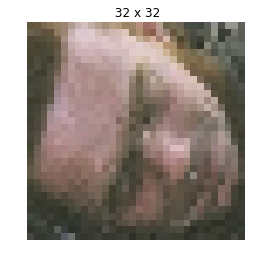

1


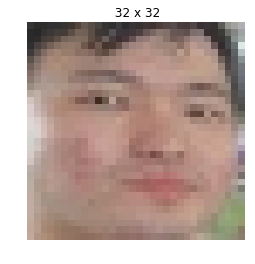

In [13]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
data_provider = slim.dataset_data_provider.DatasetDataProvider(whimh2_train_png,\
                                                               common_queue_capacity=32, common_queue_min=1)
image, label = data_provider.get(['image', 'label'])
    
with tf.Session() as sess:    
    with slim.queues.QueueRunners(sess):
        for i in xrange(2):
            np_image, np_label = sess.run([image, label])
            height, width, _ = np_image.shape
            print np_label
            plt.figure()
            plt.imshow(np_image)
            plt.title(' %d x %d' % ( height, width))
            plt.axis('off')
            plt.show()

###  [Sec3-1]Yes , we successfully make it up, wrapper these mess up, and make a clean example

In [14]:
import tensorflow as tf
import tensorflow.contrib.slim.nets 
vgg = tf.contrib.slim.nets.vgg

In [15]:
def load_batch(dataset, batch_size=32):
    """Loads a single batch of data.
    
    Args:
      dataset: The dataset to load.
      batch_size: The number of images in the batch.
      height: The size of each image after preprocessing.
      width: The size of each image after preprocessing.
      is_training: Whether or not we're currently training or evaluating.
    
    Returns:
      images: A Tensor of size [batch_size, height, width, 3], image samples that have been preprocessed.
      images_raw: A Tensor of size [batch_size, height, width, 3], image samples that can be used for visualization.
      labels: A Tensor of size [batch_size], whose values range between 0 and dataset.num_classes.
    """
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32,
        common_queue_min=8)
    
    image_raw, label = data_provider.get(['image', 'label'])
    
    # Batch it up.
#     images_raw, labels = tf.train.batch(
#       [image_raw, label],
#       batch_size=batch_size,
#       num_threads=4,
#       capacity=2 * batch_size)
    images_raw, labels = tf.train.shuffle_batch(
        [image_raw, label], batch_size=batch_size, num_threads=4,
        capacity=1000 + 3 * batch_size,
        min_after_dequeue=1000)
    
    return images_raw, labels


In [16]:
tf.reset_default_graph()
train_dir = '/tmp/loser_trail/'
dataset_dir = 'whimh2_train_png.tfrecords'
num_samples = data['X_train'].shape[0]

#load data from dataset
whimh2_train_png =Create_Slim_DateSet(dataset_dir,num_samples)
images,labels = load_batch(whimh2_train_png, batch_size=16)
image_large=tf.image.resize_images(images,[224,224])

#concate vgg
with slim.arg_scope(vgg.vgg_arg_scope()):
    predictions, _ =vgg.vgg_16(image_large,5)
    

# Specify the loss function:
one_hot_labels = slim.one_hot_encoding(labels, 5)
loss=tf.losses.softmax_cross_entropy(onehot_labels=one_hot_labels,\
                                                                 weights=1.0/16,\
                                                                 logits=predictions)

total_loss = tf.losses.get_total_loss()

predictions = tf.argmax(predictions, 1)
ground_truth = tf.argmax(one_hot_labels, 1)
acc = tf.reduce_mean(tf.cast(tf.equal(predictions, ground_truth), tf.float32))


tf.summary.scalar('losses/Total_Loss', total_loss)
tf.summary.scalar('losses/accuracy', acc)

# Specify the optimizer and create the train op:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)
train_op = slim.learning.create_train_op(total_loss, optimizer)

# Run the training:
final_loss = slim.learning.train(
    train_op,
    logdir=train_dir,
    number_of_steps=9000,
    log_every_n_steps=100,
    save_summaries_secs=300)

INFO:tensorflow:Starting Session.
INFO:tensorflow:Starting Queues.
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:global step 100: loss = 0.7047 (0.37 sec/step)
INFO:tensorflow:global step 200: loss = 0.5690 (0.37 sec/step)
INFO:tensorflow:global step 300: loss = 0.5249 (0.39 sec/step)
INFO:tensorflow:global step 400: loss = 0.5007 (0.38 sec/step)
INFO:tensorflow:global step 500: loss = 0.4466 (0.44 sec/step)
INFO:tensorflow:global step 600: loss = 0.4028 (0.38 sec/step)
INFO:tensorflow:global step 700: loss = 0.3704 (0.38 sec/step)
INFO:tensorflow:global_step/sec: 2.61678
INFO:tensorflow:global step 800: loss = 0.3902 (0.38 sec/step)
INFO:tensorflow:global step 900: loss = 0.3314 (0.37 sec/step)
INFO:tensorflow:global step 1000: loss = 0.3316 (0.37 sec/step)
INFO:tensorflow:global step 1100: loss = 0.2903 (0.37 sec/step)
INFO:tensorflow:global step 1200: loss = 0.3259 (0.37 sec/step)
INFO:tensorflow:global step 1300: loss = 0.2882 (0.37 sec/step)
INFO:tensorflow:global step 1400: 

### [Sec 3-2] since the learning train is hard to play with early stop

let's replace slim.learning.train with the original queue

In [22]:
def queue_wrapper(coord,sess,train_op,acc):
    try:
        step = 0
        while not coord.should_stop():
            start_time = time.time()
            _, loss_value,acc_value = sess.run([train_op, total_loss,acc])
            duration = time.time() - start_time
            # Print an overview fairly often.
            if step % 300 == 0:
                 print('Step %d: loss = %.2f ,acc =%.2f' % (step, loss_value,acc_value))
            step += 1
    except tf.errors.OutOfRangeError:
        print('Done training for , %d steps.' % ( step))
    finally:
        # When done, ask the threads to stop.
        coord.request_stop()
    # Wait for threads to finish.

    coord.join(threads)
    sess.close()

In [23]:
import time
tf.reset_default_graph()
train_dir = '/tmp/loser_trail/'
dataset_dir = 'whimh2_train_png.tfrecords'
num_samples = data['X_train'].shape[0]

#load data from dataset
whimh2_train_png =Create_Slim_DateSet(dataset_dir,num_samples)
images,labels = load_batch(whimh2_train_png, batch_size=16)
image_large=tf.image.resize_images(images,[224,224])

#concate vgg
with slim.arg_scope(vgg.vgg_arg_scope()):
    predictions, _ =vgg.vgg_16(image_large,5)
    

# Specify the loss function:
one_hot_labels = slim.one_hot_encoding(labels, 5)
loss=tf.losses.softmax_cross_entropy(onehot_labels=one_hot_labels,\
                                                                 weights=1.0/16,\
                                                                 logits=predictions)

total_loss = tf.losses.get_total_loss()

predictions = tf.argmax(predictions, 1)
ground_truth = tf.argmax(one_hot_labels, 1)
acc = tf.reduce_mean(tf.cast(tf.equal(predictions, ground_truth), tf.float32))


tf.summary.scalar('losses/Total_Loss', total_loss)
tf.summary.scalar('losses/accuracy', acc)

# Specify the optimizer and create the train op:
train_op = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(total_loss)

# The op for initializing the variables.
init_op = tf.group(tf.global_variables_initializer(),
tf.local_variables_initializer())

# Create a session for running operations in the Graph.
sess = tf.Session()

# Initialize the variables (the trained variables and the epoch counter).
sess.run(init_op)

# Start input enqueue threads.
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess, coord=coord)
queue_wrapper(coord,sess,train_op,acc)

Step 0: loss = 2.32 ,acc =0.12
Step 300: loss = 0.60 ,acc =0.88
Step 600: loss = 0.50 ,acc =0.94


KeyboardInterrupt: 

### [Sec3-3] I wanna check if with numpy array is more faster than png format

In [5]:
# Create the two pipe queue/thread/decode/reader function first

def read_and_decode(filename_queue):
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    
    features = tf.parse_single_example(
        serialized_example,
        # Defaults are not specified since both keys are required.
        features={
            'image_raw': tf.FixedLenFeature([], tf.string),
            'label': tf.FixedLenFeature([], tf.int64),
    })


    image = tf.decode_raw(features['image_raw'], tf.float64)
    image = tf.reshape(image,[32,32,3])
    image = tf.cast(image, tf.float32)
    label = tf.cast(features['label'], tf.int32)

    return image, label

def inputs(train, batch_size,num_epochs=10,  filename = 'whimh2_train.tfrecords'):
    if not num_epochs: num_epochs = None
    with tf.name_scope('input'):
        filename_queue = tf.train.string_input_producer([filename], num_epochs=num_epochs)
        # Even when reading in multiple threads, share the filename
        # queue.
        image, label = read_and_decode(filename_queue)
        # Shuffle the examples and collect them into batch_size batches.
        # (Internally uses a RandomShuffleQueue.)
        # We run this in two threads to avoid being a bottleneck.
        images, sparse_labels = tf.train.shuffle_batch(
            [image, label], batch_size=batch_size, num_threads=8,
            capacity=1000 + 3 * batch_size,
            # Ensures a minimum amount of shuffling of examples.
            min_after_dequeue=50)

    return images, sparse_labels

In [ ]:
tf.reset_default_graph()
train_dir = '/tmp/loser_trail/'
dataset_dir = 'whimh2_train_png.tfrecords'
num_samples = data['X_train'].shape[0]

#load data from dataset
with tf.device("/cpu:0"): 
    images, labels = inputs(train=True, batch_size=16,filename = 'whimh2_train.tfrecords')
    image_large=tf.image.resize_images(images,[224,224])

#concate vgg
with slim.arg_scope(vgg.vgg_arg_scope()):
    predictions, _ =vgg.vgg_16(image_large,5)
    

# Specify the loss function:
one_hot_labels = slim.one_hot_encoding(labels, 5)
loss=tf.losses.softmax_cross_entropy(onehot_labels=one_hot_labels,\
                                                                 weights=1.0/16,\
                                                                 logits=predictions)

total_loss = tf.losses.get_total_loss()

predictions = tf.argmax(predictions, 1)
ground_truth = tf.argmax(one_hot_labels, 1)
acc = tf.reduce_mean(tf.cast(tf.equal(predictions, ground_truth), tf.float32))


tf.summary.scalar('losses/Total_Loss', total_loss)
tf.summary.scalar('losses/accuracy', acc)

# Specify the optimizer and create the train op:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)
train_op = slim.learning.create_train_op(total_loss, optimizer)

# Run the training:
final_loss = slim.learning.train(
    train_op,
    logdir=train_dir,
    number_of_steps=9000,
    log_every_n_steps=100,
    save_summaries_secs=300)

# [Sec4] Fine-Tuning Existing Models